In [36]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import re
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from IPython.core.pylabtools import figsize
import numpy as np
from io import StringIO
import math
import seaborn as sns

In [2]:
def get_season_game_scrap(season, year) :
    
    scores_all_months = []
   
    if season == 'RS':
        months_list = ['october', 'november', 'december', 'january', 'february', 'march', 'april']
    elif season == 'PO':
         months_list = ['april', 'may', 'june']

    
    for i in months_list:
        url = "https://www.basketball-reference.com/leagues/NBA_"+ year + "_games-" + i + ".html"
        
        # this is the html from the given url
        html = urlopen(url)
        soup = BeautifulSoup(html , "lxml")
    
        column_headers = []
        for th in soup.findAll('tr', limit=2)[0].findAll('th'):
            column_headers.append(th.getText())
    
        data_rows = soup.findAll('tr')[1:]

        match_data_month = []  # create an empty list to hold all the data

        for i in range(len(data_rows)):  # for each table row
            match_row = []  # create an empty list for each pick/player

            # for each table data element from each table row
            for td in data_rows[i].findAll(re.compile('t[dh]')):        
                # get the text content and append to the player_row 
                match_row.append(td.getText())        

            # then append each pick/player to the player_data matrix
            match_data_month.append(match_row)

        df = pd.DataFrame(match_data_month, columns=column_headers)

        try:
            playoffs_start = df.loc[df['Date'] == 'Playoffs'].index[0]
        except :
            df = df
        else:
            if season == 'RS':
                df = df[df.index < playoffs_start]
            elif  season == 'PO':
                df = df[df.index > playoffs_start]
        
        scores_all_months.append(df)
    
    scores_regular_season = pd.concat(scores_all_months)
    scores_regular_season = scores_regular_season.iloc[:, 2:6]
    scores_regular_season.columns=['away_long','away_points', 'home_long','home_points']
    
    return(scores_regular_season)

In [3]:
year = '2017'

reg_season = get_season_game_scrap('RS', year)
print(reg_season.head())
#play_offs = get_season_game_scrap('PO', year)
#print(play_offs.head())

           away_long away_points               home_long home_points
0    New York Knicks          88     Cleveland Cavaliers         117
1  San Antonio Spurs         129   Golden State Warriors         100
2          Utah Jazz         104  Portland Trail Blazers         113
3      Brooklyn Nets         117          Boston Celtics         122
4   Dallas Mavericks         121          Indiana Pacers         130


In [4]:
def get_season_ranking(year):
    
    url = 'https://www.basketball-reference.com/leagues/NBA_'+ year + '.html'
    html = urlopen(url)
    soup = BeautifulSoup(html , "lxml")


    tables_list = soup.findAll('table')
    
    df_all = []
    for table in tables_list[:2]:
        rows = table.findAll('tr')

        column_headers = []
        for th in rows[0].findAll('th'):
            column_headers.append(th.getText())

        data_rows = rows[1:]
        #print(data_rows)

        match_data_month = []
        for i in range(len(data_rows)):  # for each table row
            match_row = []  # create an empty list for each pick/player

            #for each table data element from each table row
            for td in data_rows[i].findAll(re.compile('t[dh]')):        
                # get the text content and append to the player_row 
                match_row.append(td.getText())        

            # then append each pick/player to the player_data matrix
            match_data_month.append(match_row)

        #print(match_data_month)
        df = pd.DataFrame(match_data_month, columns=column_headers)
        df_all.append(df)
    
    return(df_all)

In [47]:
east_standing = get_season_ranking(year)[0]
print(east_standing)
west_standing = get_season_ranking(year)[1]
print(west_standing)

           Eastern Conference   W   L  W/L%    GB   PS/G   PA/G    SRS
0        Boston Celtics* (1)   53  29  .646     —  108.0  105.4   2.25
1   Cleveland Cavaliers* (2)   51  31  .622   2.0  110.3  107.2   2.87
2       Toronto Raptors* (3)   51  31  .622   2.0  106.9  102.6   3.65
3    Washington Wizards* (4)   49  33  .598   4.0  109.2  107.4   1.36
4         Atlanta Hawks* (5)   43  39  .524  10.0  103.2  104.0  -1.23
5       Milwaukee Bucks* (6)   42  40  .512  11.0  103.6  103.8  -0.45
6        Indiana Pacers* (7)   42  40  .512  11.0  105.1  105.3  -0.64
7         Chicago Bulls* (8)   41  41  .500  12.0  102.9  102.4   0.03
8             Miami Heat (9)   41  41  .500  12.0  103.2  102.1   0.77
9       Detroit Pistons (10)   37  45  .451  16.0  101.3  102.5  -1.29
10    Charlotte Hornets (11)   36  46  .439  17.0  104.9  104.7  -0.07
11      New York Knicks (12)   31  51  .378  22.0  104.3  108.0  -3.87
12        Orlando Magic (13)   29  53  .354  24.0  101.1  107.6  -6.61
13   P

In [48]:
Team_dict = {'Atlanta Hawks': 'ATL',
 'Boston Celtics': 'BOS',
 'Brooklyn Nets': 'BKN',
 'Charlotte Hornets': 'CHA',
 'Chicago Bulls': 'CHI',
 'Cleveland Cavaliers': 'CLE',
 'Dallas Mavericks': 'DAL',
 'Denver Nuggets': 'DEN',
 'Detroit Pistons': 'DET',
 'Golden State Warriors': 'GSW',
 'Houston Rockets': 'HOU',
 'Indiana Pacers': 'IND',
 'Los Angeles Clippers': 'LAC',
 'Los Angeles Lakers': 'LAL',
 'Memphis Grizzlies': 'MEM',
 'Miami Heat': 'MIA',
 'Milwaukee Bucks': 'MIL',
 'Minnesota Timberwolves': 'MIN',
 'New Orleans Pelicans': 'NOP',
 'New York Knicks': 'NYK',
 'Oklahoma City Thunder': 'OKC', 
 'Orlando Magic': 'ORL',
 'Philadelphia 76ers': 'PHI', 
 'Phoenix Suns': 'PHX',
 'Portland Trail Blazers': 'POR', 
 'Sacramento Kings': 'SAC',
 'San Antonio Spurs': 'SAS',
 'Toronto Raptors': 'TOR',
 'Utah Jazz': 'UTA',
 'Washington Wizards': 'WAS'
}

In [49]:
df = reg_season
df['home'] = df['home_long'].map(Team_dict)
df['away'] = df['away_long'].map(Team_dict)

teams = df.home.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='home', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)

observed_home_points = df.home_points.values
observed_away_points = df.away_points.values

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.home.unique())
num_games = len(df)


In [14]:
model = pm.Model()

with pm.Model() as model:
    # global model parameters
    home = pm.Flat('home')
    sd_att = pm.Gamma('sd_att', .1, .1)
    sd_def = pm.Gamma('sd_def', .1, .1)
    intercept = pm.Flat('intercept')

    # team-specific model parameters
    atts_star = pm.Normal('atts_star', mu=0, sd=sd_att, shape=num_teams)
    defs_star = pm.Normal('defs_star', mu=0, sd=sd_def, shape=num_teams)
    
    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])
    
    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_points)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_points)

In [15]:
with model:
    trace = pm.sample(50000, tune=1000)
    pm.traceplot(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 9,435.5:  20%|█▉        | 39096/200000 [00:27<01:51, 1449.02it/s]   
Convergence archived at 39200
Interrupted at 39,200 [19%]: Average Loss = 1.4149e+05
100%|██████████| 51000/51000 [07:11<00:00, 118.14it/s]


In [53]:
avg_att = pm.df_summary(trace, varnames=['atts'])['mean']
avg_def = pm.df_summary(trace, varnames=['defs'])['mean']

hpd_low_att = pm.df_summary(trace, varnames=['atts'])['hpd_2.5']
hpd_high_att = pm.df_summary(trace, varnames=['atts'])['hpd_97.5']

hpd_low_def = pm.df_summary(trace, varnames=['defs'])['hpd_2.5']
hpd_high_def  = pm.df_summary(trace, varnames=['defs'])['hpd_97.5']

labels = list(teams['team'])

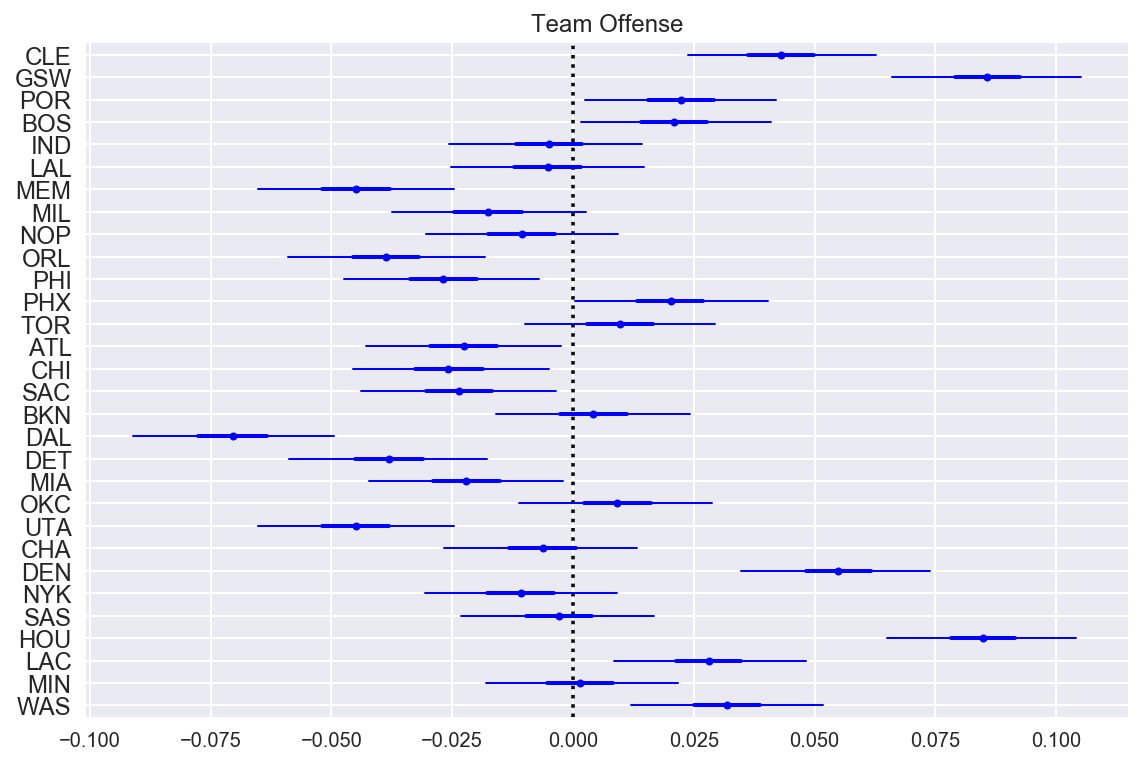

In [52]:
pm.forestplot(trace, varnames=['atts'], ylabels = labels, main="Team Offense")

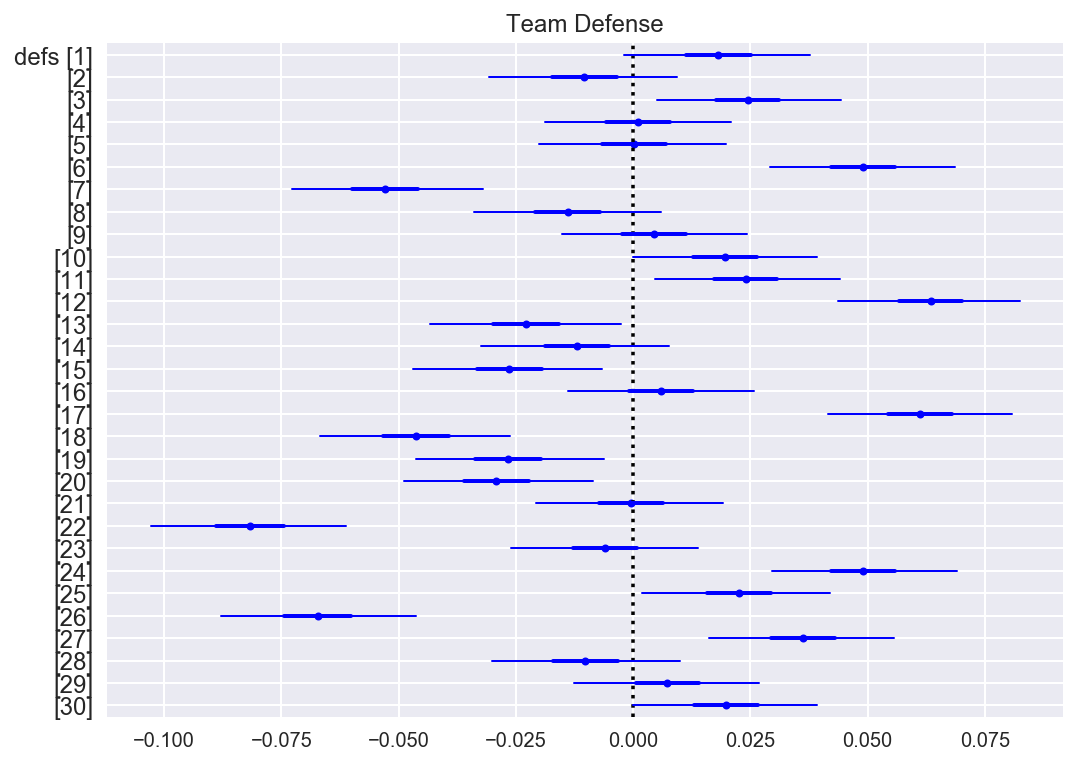

In [54]:
pm.forestplot(trace, varnames=['defs'], ylabels = labels, main="Team Defense")

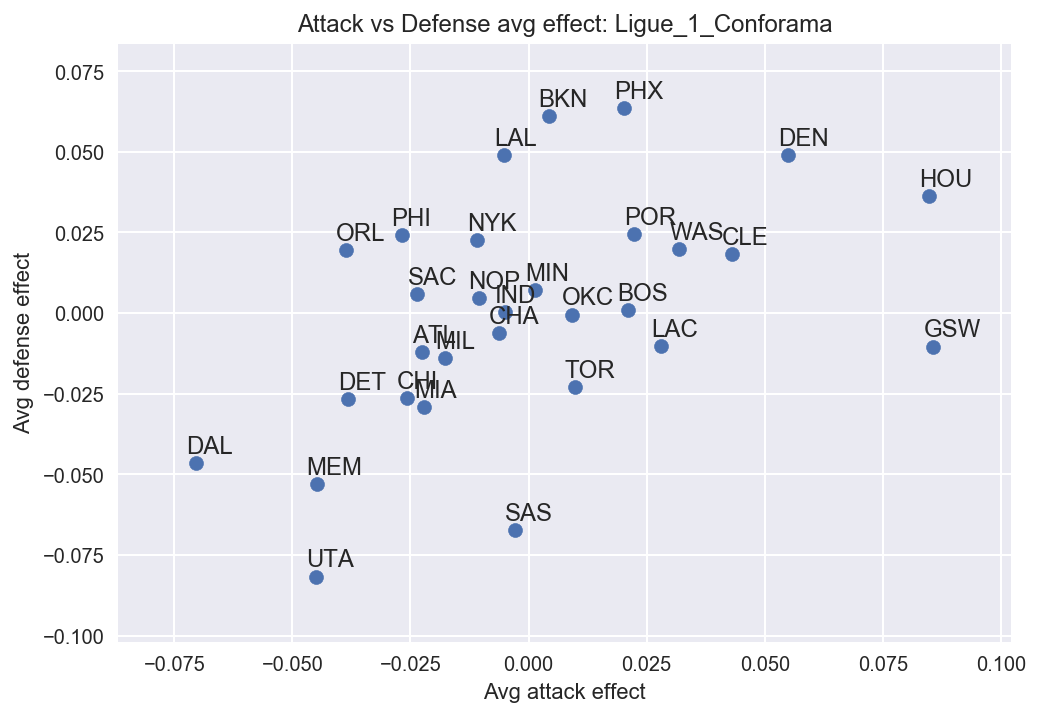

In [55]:
fig, ax = plt.subplots()
ax.scatter(
   x=avg_att, y=avg_def, marker='o', cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(labels, avg_att, avg_def):
    ax.annotate(label, xy=(x, y), xytext = (-5,5), textcoords = 'offset points')
ax.set_title('Attack vs Defense avg effect: Ligue_1_Conforama')
ax.set_xlabel('Avg attack effect')
ax.set_ylabel('Avg defense effect')

In [56]:
def trace_quantiles(x):
    return pd.DataFrame(pm.quantiles(x, [50]))

In [57]:
df_hpd_med = pm.df_summary(trace, ['atts'], stat_funcs=[trace_quantiles])
df_hpd_med.columns = ['hpd_med_att']

df_hpd = pd.DataFrame( {'hpd_high_att' : hpd_high_att, 
                        'hpd_low_att' : hpd_low_att,
                        'teams' : labels })

df_hpd = df_hpd.join(df_hpd_med)

df_hpd['relative_lower'] = df_hpd.hpd_med_att - df_hpd.hpd_low_att
df_hpd['relative_upper'] = df_hpd.hpd_high_att - df_hpd.hpd_med_att
df_hpd = df_hpd.sort_values(by='hpd_med_att')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5

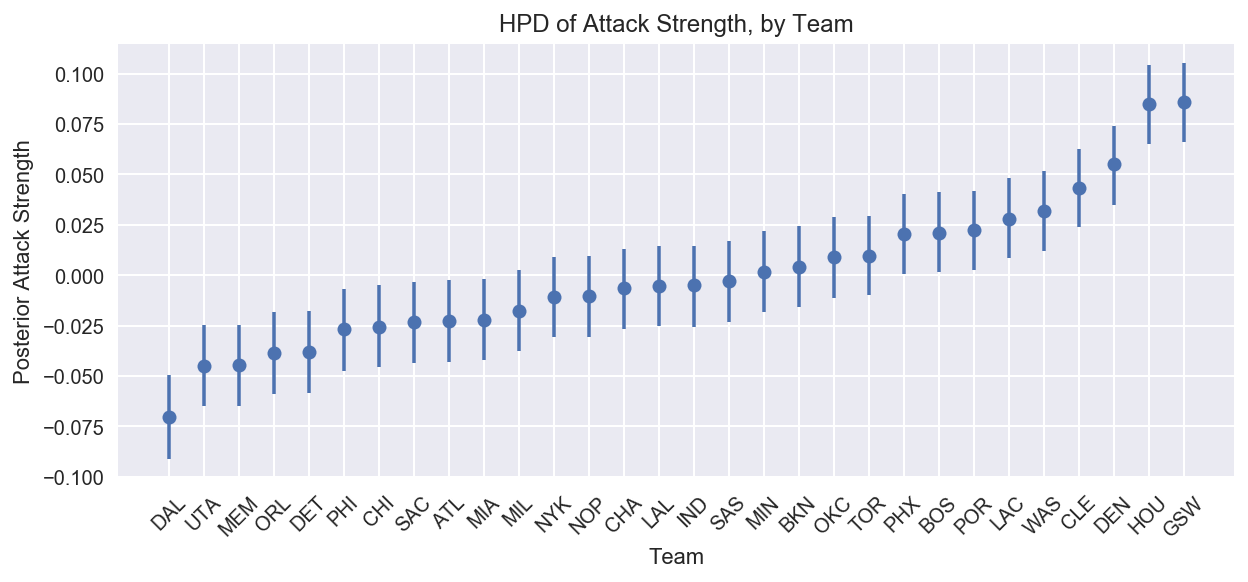

In [58]:
fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_med_att, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('HPD of Attack Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(df_hpd.index + .5)

_= axs.set_xticklabels(df_hpd['teams'].values, rotation=45)

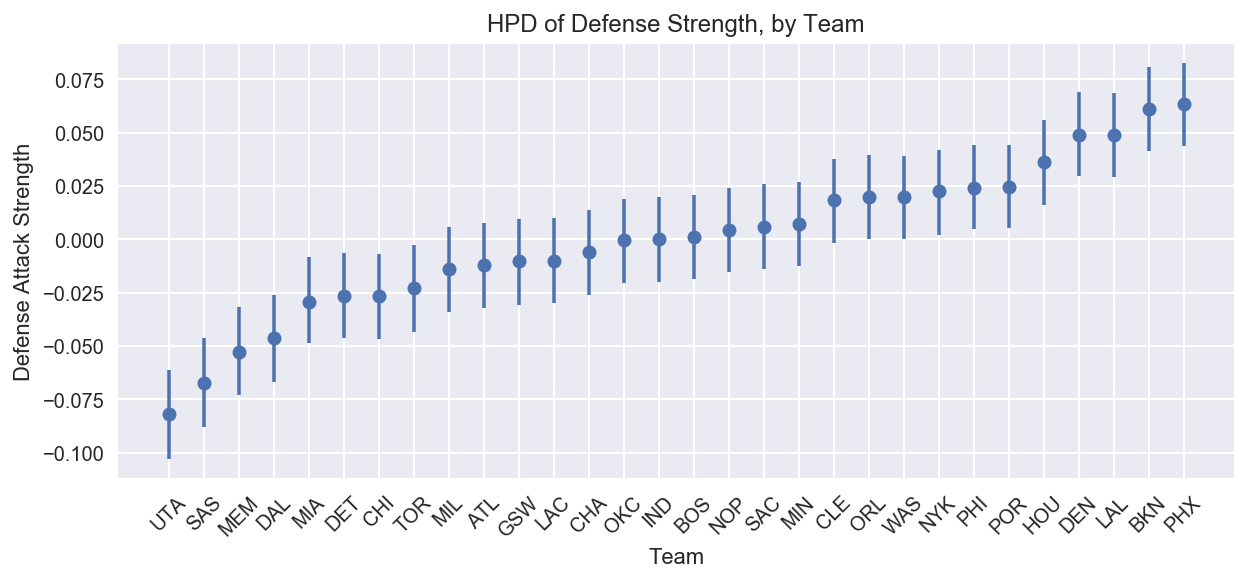

In [59]:
df_hpd_def_med = pm.df_summary(trace, ['defs'], stat_funcs=[trace_quantiles])
df_hpd_def_med.columns = ['hpd_med_def']

df_hpd_def = pd.DataFrame( {'hpd_high_def' : hpd_high_def, 
                        'hpd_low_def' : hpd_low_def,
                        'teams' : labels })

df_hpd_def = df_hpd_def.join(df_hpd_def_med)
df_hpd_def['relative_lower'] = df_hpd_def.hpd_med_def - df_hpd_def.hpd_low_def
df_hpd_def['relative_upper'] = df_hpd_def.hpd_high_def - df_hpd_def.hpd_med_def
df_hpd_def = df_hpd_def.sort_values(by='hpd_med_def')
df_hpd_def = df_hpd_def.reset_index()
df_hpd_def['x'] = df_hpd_def.index + .5

fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd_def.x, df_hpd_def.hpd_med_def, 
             yerr=(df_hpd_def[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('HPD of Defense Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Defense Attack Strength')
_= axs.set_xticks(df_hpd_def.index + .5)
_= axs.set_xticklabels(df_hpd_def['teams'].values, rotation=45)

In [ ]:
num_samples = trace['atts'].shape[0]
draw = np.random.randint(0, num_samples)
atts_draw = pd.DataFrame({'att':  trace['atts'][draw]})
defs_draw = pd.DataFrame({'def':  trace['defs'][draw]})
home_draw = trace['home'][draw]
intercept_draw = trace['intercept'][draw]
season = df.copy()
season = pd.merge(season, atts_draw, left_on='i_home', right_index=True)
season = pd.merge(season, defs_draw, left_on='i_home', right_index=True)
season = season.rename(columns = {'att': 'att_home', 'def': 'def_home'})
season = pd.merge(season, atts_draw, left_on='i_away', right_index=True)
season = pd.merge(season, defs_draw, left_on='i_away', right_index=True)
season = season.rename(columns = {'att': 'att_away', 'def': 'def_away'})
season['home'] = home_draw
season['intercept'] = intercept_draw
season['home_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                       x['home'] + 
                                                       x['att_home'] + 
                                                       x['def_away']), axis=1)
season['away_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                       x['att_away'] + 
                                                       x['def_home']), axis=1)
season['home_points'] = season.apply(lambda x: np.random.poisson(x['home_theta']), axis=1)
season['away_points'] = season.apply(lambda x: np.random.poisson(x['away_theta']), axis=1)
season['home_outcome'] = season.apply(lambda x: 'win' if x['home_points'] > x['away_points'] else 
                                                'loss' if x['home_points'] < x['away_points'] else 'draw', axis=1)
season['away_outcome'] = season.apply(lambda x: 'win' if x['home_points'] < x['away_points'] else 
                                                'loss' if x['home_points'] > x['away_points'] else 'draw', axis=1)
season['home_win'] = season.apply(lambda x: 1 if x['home_outcome'] == 'win' else 0, axis = 1)
season['home_loss'] = season.apply(lambda x: 1 if x['home_outcome'] == 'loss' else 0, axis = 1)
season['home_draw'] = season.apply(lambda x: 1 if x['home_outcome'] == 'draw' else 0, axis = 1)
season[(season['home_draw'] == 1)

print(draw)

In [98]:
def simulate_season():
    """
    Simulate a season once, using one random draw from the mcmc chain. 
    """
    num_samples = trace['atts'].shape[0]
    draw = np.random.randint(0, num_samples)
    atts_draw = pd.DataFrame({'att':  trace['atts'][draw]})
    defs_draw = pd.DataFrame({'def':  trace['defs'][draw]})
    home_draw = trace['home'][draw]
    intercept_draw = trace['intercept'][draw]
    season = df.copy()
    season = pd.merge(season, atts_draw, left_on='i_home', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_home', right_index=True)
    season = season.rename(columns = {'att': 'att_home', 'def': 'def_home'})
    season = pd.merge(season, atts_draw, left_on='i_away', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_away', right_index=True)
    season = season.rename(columns = {'att': 'att_away', 'def': 'def_away'})
    season['home'] = home_draw
    season['intercept'] = intercept_draw
    season['home_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['home'] + 
                                                           x['att_home'] + 
                                                           x['def_away']), axis=1)
    season['away_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['att_away'] + 
                                                           x['def_home']), axis=1)
    

    
    
    season['home_points'] = season.apply(lambda x: np.random.poisson(x['home_theta']), axis=1)
    season['away_points'] = season.apply(lambda x: np.random.poisson(x['away_theta']), axis=1)
    season['home_outcome'] = season.apply(lambda x: 'win' if x['home_points'] > x['away_points'] else 
                                                    'loss' if x['home_points'] < x['away_points'] else 'draw', axis=1)
    season['away_outcome'] = season.apply(lambda x: 'win' if x['home_points'] < x['away_points'] else 
                                                    'loss' if x['home_points'] > x['away_points'] else 'draw', axis=1)
    season['home_win'] = season.apply(lambda x: 1 if x['home_outcome'] == 'win' else 0, axis = 1)
    season['home_loss'] = season.apply(lambda x: 1 if x['home_outcome'] == 'loss' else 0, axis = 1)
    season['home_draw'] = season.apply(lambda x: 1 if x['home_outcome'] == 'draw' else 0, axis = 1)
    season['away_win'] = season.apply(lambda x: 1 if x['away_outcome'] == 'win' else 0, axis = 1)
    season['away_loss'] = season.apply(lambda x: 1 if x['away_outcome'] == 'loss' else 0, axis = 1)
    season['away_draw'] = season.apply(lambda x: 1 if x['away_outcome'] == 'draw' else 0, axis = 1)
    return season

def create_season_table(season):
    """
    Using a season dataframe output by simulate_season(), create a summary dataframe with wins, losses, goals for, etc.
    
    """
    g = season.groupby('i_home')    
    home = pd.DataFrame({'home_points': g.home_points.sum(),
                         'home_points_against': g.away_points.sum(),
                         'home_wins': g.home_win.sum(),
                         'home_draws': g.home_draw.sum(),
                         'home_losses': g.home_loss.sum()
                         })
    g = season.groupby('i_away')    
    away = pd.DataFrame({'away_goals': g.away_points.sum(),
                         'away_goals_against': g.home_points.sum(),
                         'away_wins': g.away_win.sum(),
                         'away_draws': g.away_draw.sum(),
                         'away_losses': g.away_loss.sum()
                         })
    df = home.join(away)
    df['wins'] = df.home_wins + df.away_wins
    df['draws'] = df.home_draws + df.away_draws
    df['losses'] = df.home_losses + df.away_losses
    df['per_win'] = df.wins / (df.wins+ df.losses)
    df = pd.merge(teams, df, left_on='i', right_index=True)
    df = df.sort_values(by='per_win', ascending=False)
    df = df.reset_index()
    return df

def simulate_seasons(n=100):
    dfs = []
    for i in range(n):
        if (i % 200) == 0:
            print(i)
        s = simulate_season()
        t = create_season_table(s)
        t['iteration'] = i
        print(t)
        dfs.append(t)
    return pd.concat(dfs, ignore_index=True)

In [ ]:
simuls = simulate_seasons(3)

0


C:\toolkits.win\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


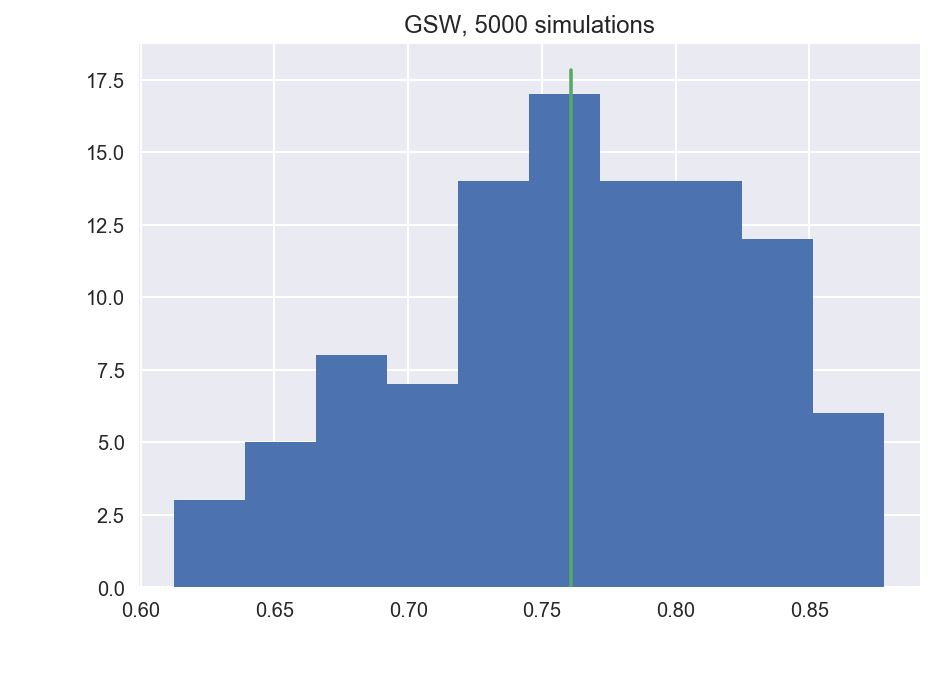

In [83]:
ax = simuls.per_win[simuls.team == 'GSW'].hist(figsize=(7,5))
median = simuls.per_win[simuls.team == 'GSW'].median()
ax.set_title('GSW, 5000 simulations')
ax.plot([median, median], ax.get_ylim())
plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))

In [1]:
ax = simuls.per_win[simuls.team == 'BKN'].hist(figsize=(7,5))
median = simuls.per_win[simuls.team == 'BKN'].median()
ax.set_title('BKN, 5000 simulations')
ax.plot([median, median], ax.get_ylim())
plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))

NameError: name 'simuls' is not defined